In [1]:
#from jax import jit, vmap, random
#import jax.numpy as np
import numpy as np
import pandas as pd
import datetime
#import jax

# enable float 64
#from jax.config import config

# config.update('jax_enable_x64', True)

In [2]:
# https://github.com/google/jax/issues/10144
def binomial_transition(xi, tau, dt=1):
    kb    = np.maximum(1.0 - np.exp(-tau*dt), 0)
    pop   = np.random.binomial(list(xi), kb )
    return pop

def checkpopvars(x, pop):
    return np.clip(x, 0, pop)

def f(t, x, beta, gamma, N=1e6, dt=1):
    S   = x[0, :]   # Susceptibles
    I   = x[1, :]   # Infected Reported
    R   = x[2, :]   # Recovered

    foi =  beta * (I) / N

    # Stochastic transitions
    s2i     =  binomial_transition(S, foi * dt)    # susceptible to exposed
    i2r     =  binomial_transition(I, gamma * dt) # exposed to infected reported who are not going to die

    # Updates
    S    = S   - s2i       # Susceptible
    I    = I   + s2i - i2r # Infected reported
    R    = R   + i2r       # Recovered
    C    = s2i

    return checkpopvars(np.array([S, I, R, C]), N)

def g(t, x, report_rate):
    """
    Observational model.
        Args:
            t: time
            x: state space
            θ: parameters
            ρ: report rate
    """
    y = np.random.binomial(list(x[3, :]), report_rate)
    return y

def f0(pop=1e6, inf_init=0.01, m=300):
    """
    Initial guess of the state space.
    """
    I0 = pop * inf_init
    S0 = pop - I0
    R0 = 0
    C0 = I0

    x0 = np.ones((4, m)) * np.expand_dims(np.array([S0, I0, R0, C0]), -1)
    return x0

In [3]:
R0    = 2.5
gamma = 1/4
beta  = R0*gamma
N     = 1e6

beta_truth        = beta
gamma_truth       = gamma
report_rate_truth = 0.3

T     = 70
dt    = 1
ens   = 500
x0    = f0(N, 0.1, m=ens)
x_sim = x0

x_sim          = np.full((4, T, ens), np.nan)
x_sim[:, 0, :] = x0

for t in range(1, T):
    x_sim[:, t, :]  = f(t, x_sim[:, t-1, :], beta_truth, gamma_truth, N, dt=dt)
C =  np.random.binomial(list(x_sim[3, :, :]), report_rate_truth)

obs_use   = C[:, np.random.randint(ens)]
obs_use_n = obs_use# + np.squeeze(jax.random.normal(k, shape=(T, 1))*0.5), 0)


In [4]:
def simulate_model(f, f0, g, teta, model_settings):
    """
    Simulate a model.
    """

    n    = model_settings['n']
    k    = model_settings['k']
    p, m = teta.shape
    x0   = f0(teta)

    x_sim          = np.full((n, T, m), np.nan)
    x_sim[:, 0, :] = x0

    obs              = np.full((k, T, m), np.nan)
    obs[:, 0, :]   = g(0, x_sim[:, 0, :], teta)


    for t, date in enumerate(model_settings["dates"][1:]):
        x_sim[:, t+1, :] = f(t, x_sim[:, t, :], teta)
        obs[:, t+1, :]   = g(t, x_sim[:, t+1, :], teta)

    return x_sim, obs


In [5]:
observation_df          = pd.DataFrame(obs_use_n, columns=['y1'])
observation_df["oev1"]  = np.maximum(20, 1 +( 0.2 * observation_df["y1"].values)**2)
observation_df["date"] = pd.date_range(start=datetime.datetime(2020, 1, 1), periods=T, freq='D')


In [6]:
from ifeakf import ifeakf

model_settings = {
    "m"           : 500,                                         # number of ensembles
    "p"           : 3,                                           # number of parameters
    "k"           : 1,                                           # number of observations
    "n"           : 4,                                           # number of state variables / dimension of the state space
    "dt"          : 1,                                           # time step
    "param_name"  : ["β", "γ", "ρ"],                             # name of the parameters
    "dates"       : observation_df["date"].values,               # integration dates (for the process model) | date_{t+1}-date_t = dt
    "param_truth" : [beta_truth, gamma_truth, report_rate_truth] # true parameter values (not required - just for the example)
    }

if_settings = {
   "Nif"                : 40,                           # number of iterations of the IF
   "type_cooling"       : "geometric",                  # type of cooling schedule
   "shrinkage_factor"   : 0.9,                          # shrinkage factor for the cooling schedule
   "inflation"          : 1.01,                         # inflation factor for spreading the variance after the EAKF step
   "assimilation_dates" : observation_df["date"].values # assimilation dates (for the inference)
}

N     = 1e6

# Function to be used for the ikeafk function.
f_if  = lambda t, x, θ: f(t, x, θ[0, :], θ[1, :], N)
g_if  = lambda t, x, θ: g(t, x, θ[2, :])
f0_if = lambda θ: f0(pop=N, inf_init=10/100, m=model_settings["m"])


γmin = 1/15
γmax = 1/3

βmin = 0.2
βmax = 3.5

ρmin = 0.01
ρmax = 1

state_space_range = np.array([0, N])
parameters_range  = np.array([[βmin, βmax],
                              [γmin, γmax],
                              [ρmin, ρmax]])

σ_perturb = np.array([(βmax-βmin)/10, (γmax-γmin)/10, (γmax-γmin)/10])


# CALIBRATON
## The idea of the calibration is to use the estimated posterior to stop the IF-EAKF

In [7]:
# ONE ITERATION

obs_df                  = observation_df.set_index("date")#.resample("W-Sun").sum()
obs_df.index.values[-1] = model_settings["dates"][-1]
obs_df["oev1"]          = np.maximum(20, 1 +( 0.2 * obs_df["y1"].values)**2)

if_settings["assimilation_dates"] = obs_df.index.values
if_settings["Nif"] = 40
θmle, θpost = ifeakf(process_model            = f_if,
                    observational_model       = g_if,
                    state_space_initial_guess = f0_if,
                    observations_df           = obs_df,            #resample so assimilitation dates are weekly
                    parameters_range          = parameters_range,
                    state_space_range         = state_space_range,
                    model_settings            = model_settings,
                    if_settings               = if_settings,
                    perturbation              = σ_perturb)


In [8]:
from eval.calibration import calibration

θifs        = np.squeeze(np.mean(θpost, 2))
observation = np.array([obs_df.y1.values])
calibration_df = pd.DataFrame()
for if_iter in range(if_settings["Nif"]):
    θif              = θifs[:, :, if_iter]
    state_sim, y_sim = simulate_model(f_if, f0_if, g_if, θif, model_settings)
    cal_df           = calibration(y_sim, observation, observation_index=0, dates=model_settings["dates"])
    cal_df["if_iter"] = if_iter
    cal_df["score"]   = np.mean(np.abs(cal_df.quantiles.values - cal_df.proportion_inside.values))
    calibration_df    = pd.concat([calibration_df, cal_df])


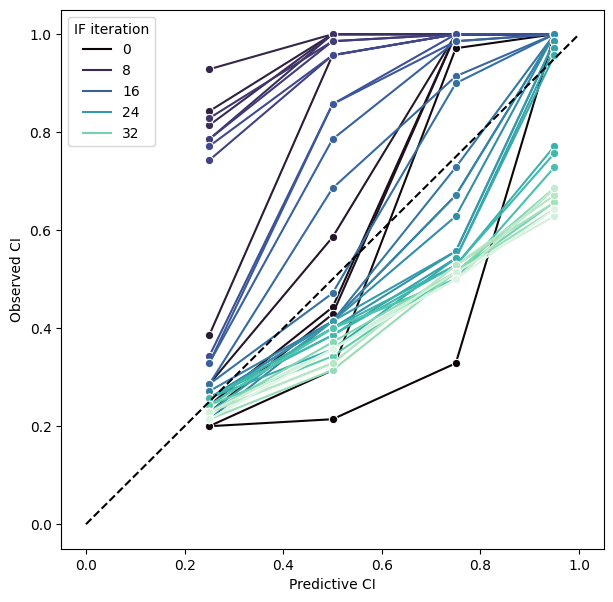

In [9]:
from eval.calibration import calibration
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
#ax.plot(cal_df.quantiles, cal_df.proportion_inside, color="red", marker="o")
sns.lineplot(ax=ax, x="quantiles", y="proportion_inside", data=calibration_df, hue="if_iter", legend=True, palette="mako", marker="o")
ax.plot(np.linspace(0,1), np.linspace(0,1), ls="--", color="k")
ax.set_xlabel("Predictive CI")
ax.set_ylabel("Observed CI")

ax.legend(title="IF iteration")

In [15]:
calibration_df

,quantiles,proportion_inside,if_iter,score
0,0.25,0.2,0,0.201786
1,0.50,0.214286,0,0.201786
2,0.75,0.328571,0,0.201786
3,0.95,1.0,0,0.201786
0,0.25,0.2,1,0.126786
...,...,...,...,...
3,0.95,0.628571,38,0.180357
0,0.25,0.214286,39,0.183929
1,0.50,0.357143,39,0.183929
2,0.75,0.5,39,0.183929


Text(0.5, 1.0, 'SIR model calibration score')

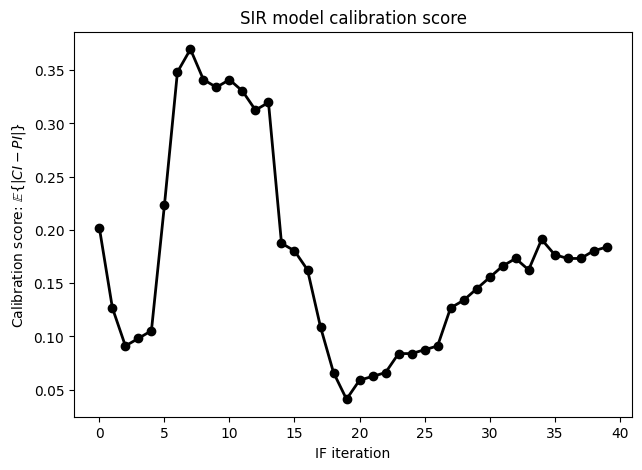

In [22]:
cal_time_df = calibration_df[["if_iter", "score"]].groupby("if_iter").mean()

fig, ax = plt.subplots(1, 1, figsize=(7.2, 5))
ax.plot(cal_time_df.index, cal_time_df.score, marker="o", lw=2, c="k")
ax.set_xlabel("IF iteration")
ax.set_ylabel(r"Calibration score: $\mathbb{E}\left\{|CI - PI|\right\}$")
ax.set_title("SIR model calibration score")

In [11]:
best_if_iteration = calibration_df[calibration_df.score==calibration_df.score.min()]["if_iter"].values[0]
θif              = θifs[:, :, best_if_iteration]
state_sim, y_sim = simulate_model(f_if, f0_if, g_if, θif, model_settings)

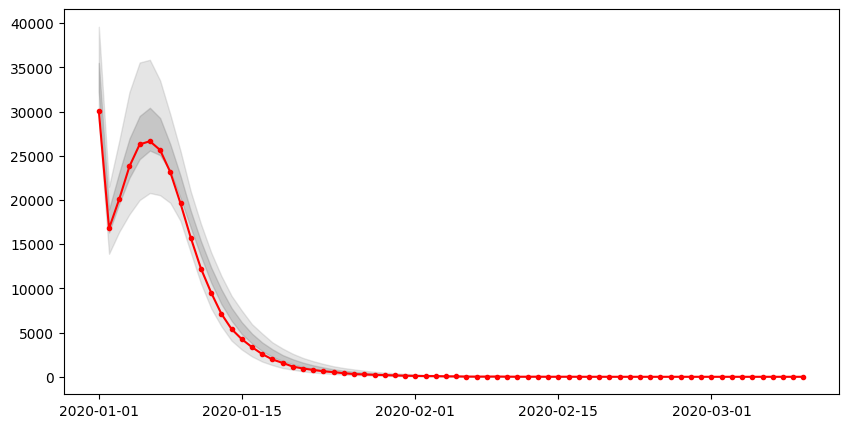

In [12]:
import matplotlib.pyplot as plt
from utils import create_df_response


sim_df = create_df_response(np.squeeze(y_sim), time=len(model_settings["dates"]), dates=model_settings["dates"]).reset_index()

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.fill_between(sim_df["date"], sim_df["low_95"], sim_df["high_95"], color="gray", alpha=0.2, label="95% CI")
ax.fill_between(sim_df["date"], sim_df["low_50"], sim_df["high_50"], color="gray", alpha=0.3, label="50% CI")
ax.plot(model_settings["dates"], np.squeeze(observation), color="red", label="Observations", marker="o", markersize=3)

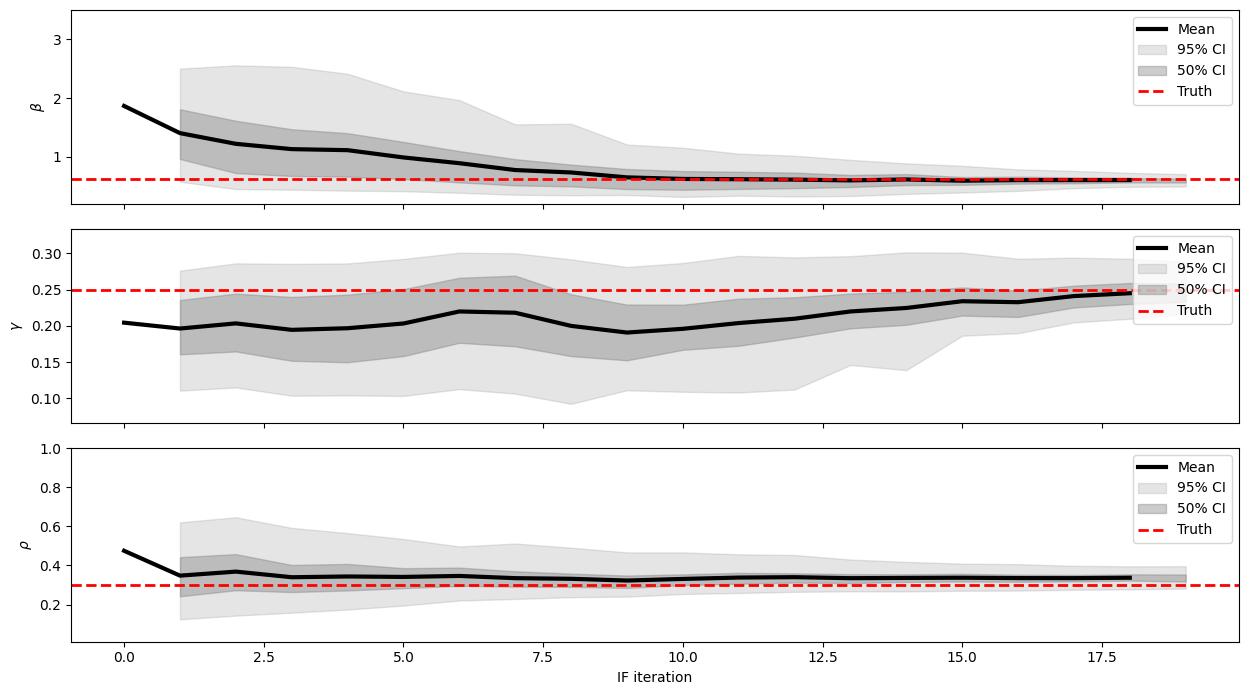

In [13]:
from diagnostic_plots import convergence_plot
from utils import create_df_response
import matplotlib.pyplot as plt

θpost_plot = θpost[:, :, :, :best_if_iteration]
beta_post  = θpost_plot[0, :, :, :].mean(1).T
gamma_post = θpost_plot[1, :, :, :].mean(1).T
rho_post   = θpost_plot[2, :, :, :].mean(1).T

p_truth = model_settings["param_truth"]
β_df    = create_df_response(beta_post,  time=len(range(best_if_iteration)))
γ_df    = create_df_response(gamma_post, time=len(range(best_if_iteration)))
ρ_df    = create_df_response(rho_post,   time=len(range(best_if_iteration)))

p_df   = [β_df, γ_df, ρ_df]
p_name = [r"$\beta$", r"$\gamma$", r"$\rho$"]

fig, ax = plt.subplots(3, 1, figsize=(12.5, 7.2), sharex=True)
convergence_plot(θmle[:, :best_if_iteration], p_df, parameters_range, param_truth=p_truth, param_label=p_name, ax=ax, fig=fig)


In [14]:
gamma_post.shape

(19, 500)